In [1]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

UMC_PATH = ".\\Universal-Mouse-Code\\"
FEATURE_LIST = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]

EPM_TRAIN_FILE = ".\\EPM_model\\EPM_train_dict_May_17.pkl"
EPM_VAL_FILE = ".\\EPM_model\\EPM_val_dict_May_17.pkl"
OFT_TRAIN_FILE_NAME = ".\\OFT_model\\OFT_train_dict_old_features_hand_picked.pkl"
OFT_VAL_FILE_NAME = ".\\OFT_model\\OFT_validation_dict_old_features_hand_picked.pkl"
FLX_TRAIN_FILE = ".\\FLX_model\\FLX_train_dict_old_features.pkl"
FLX_VAL_FILE = ".\\FLX_model\\FLX_validation_dict_old_features.pkl"
FLX_FULL_DATA_TRAIN = ".\\FLX_model\\FLX_train_dict_full_recordings.pkl"
FLX_FULL_DATA_VAL = ".\\FLX_model\\FLX_val_dict_full_recordings.pkl"
FEATURE_VECTOR = FEATURE_LIST
FEATURE_WEIGHT = [10,1,1]

sys.path.append(UMC_PATH)
#from dCSFA_model import dCSFA_model
import umc_data_tools as umc_dt
from dCSFA_NMF import dCSFA_NMF

if torch.cuda.is_available():
    device="cuda:0"
else:
    device="cpu"


print("Using device: %s"%(device))

Using device: cuda:0


In [2]:
with open(FLX_TRAIN_FILE,"rb") as f:
    flx_train_dict = pickle.load(f)

with open(FLX_VAL_FILE,"rb") as f:
    flx_validation_dict = pickle.load(f)
    
#scale_vector = np.array([np.arange(1,57) for feature in range(64)]).flatten()
#Load the data
running_idx = 0
feature_groups = []
for idx,feature in enumerate(FEATURE_LIST):
    f_begin = running_idx
    f_end = f_begin + flx_train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

flx_X_train = np.hstack([flx_train_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
flx_y_train = flx_train_dict['y_flx']
flx_y_mouse_train = flx_train_dict['y_mouse']
flx_y_expDate_train = flx_train_dict['y_expDate']
flx_y_time_train = flx_train_dict['y_time']

flx_X_validation = np.hstack([flx_validation_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
flx_y_validation = flx_validation_dict['y_flx']
flx_y_mouse_validation = flx_validation_dict['y_mouse']
flx_y_expDate_validation = flx_validation_dict['y_expDate']
flx_y_time_validation = flx_validation_dict['y_time']

flx_X = np.vstack([flx_X_train,flx_X_validation])
flx_y_task = np.hstack([flx_y_train,flx_y_validation])
flx_y_mouse = np.hstack([flx_y_mouse_train,flx_y_mouse_validation])
flx_y_expDate = np.hstack([flx_y_expDate_train,flx_y_expDate_validation])
flx_y_time = np.hstack([flx_y_time_train,flx_y_time_validation])
intercept_mask = OneHotEncoder().fit_transform(flx_y_mouse_train.reshape(-1,1)).todense()

In [3]:
N_COMPONENTS=20
MOMENTUM_MODEL = ".\\{}_FLX_10_res_loss_10_power_features.pt"
TRAIN = False
NETWORK_CONSTRAINT = "Positive"
DIM_IN = flx_X_train.shape[1]
'''model = dCSFA_NMF(n_components=N_COMPONENTS,dim_in=DIM_IN,device='auto',n_intercepts=intercept_mask.shape[1],
                n_sup_networks=1,optim_name='AdamW',recon_loss='IS',sup_recon_weight=1,sup_weight=1,
                useDeepEnc=True,h=256,sup_recon_type="Residual",feature_groups=feature_groups,fixed_corr='negative')

model.fit(flx_X_train,flx_y_train,intercept_mask=intercept_mask,batch_size=128,lr=1e-3,
        n_pre_epochs=100,n_epochs=1500,verbose=True,pretrain=True,best_model_name="Negative_FLX_Network_April_21_state_dict.pt")
torch.save(model,"Negative_FLX_Network_FLX_vs_Saline_April_21.pt")'''

if TRAIN:
        model = dCSFA_NMF(n_components=N_COMPONENTS,dim_in=DIM_IN,device='auto',n_intercepts=intercept_mask.shape[1],
                        n_sup_networks=1,optim_name='SGD',recon_loss='MSE',sup_recon_weight=1,sup_weight=1,
                        useDeepEnc=True,h=256,sup_recon_type="Residual",feature_groups=feature_groups,fixed_corr=NETWORK_CONSTRAINT)
        model.fit(flx_X_train,flx_y_train,intercept_mask=intercept_mask,batch_size=128,lr=1e-3,
                n_pre_epochs=100,n_epochs=1500,verbose=True,pretrain=True,best_model_name="{}_FLX_SGD_Network_July_23_state_dict.pt".format(NETWORK_CONSTRAINT),
                momentum=0.9)
        torch.save(model,MOMENTUM_MODEL.format(NETWORK_CONSTRAINT))
else:
        model = torch.load(MOMENTUM_MODEL.format(NETWORK_CONSTRAINT),map_location='cpu')
        model.device='cpu'
#model = torch.load(".\\Results-May-12\\{}_FLX_Network_FLX_vs_Saline_April_21.pt".format(NETWORK_CONSTRAINT),map_location='cpu')
#model.device='cpu'

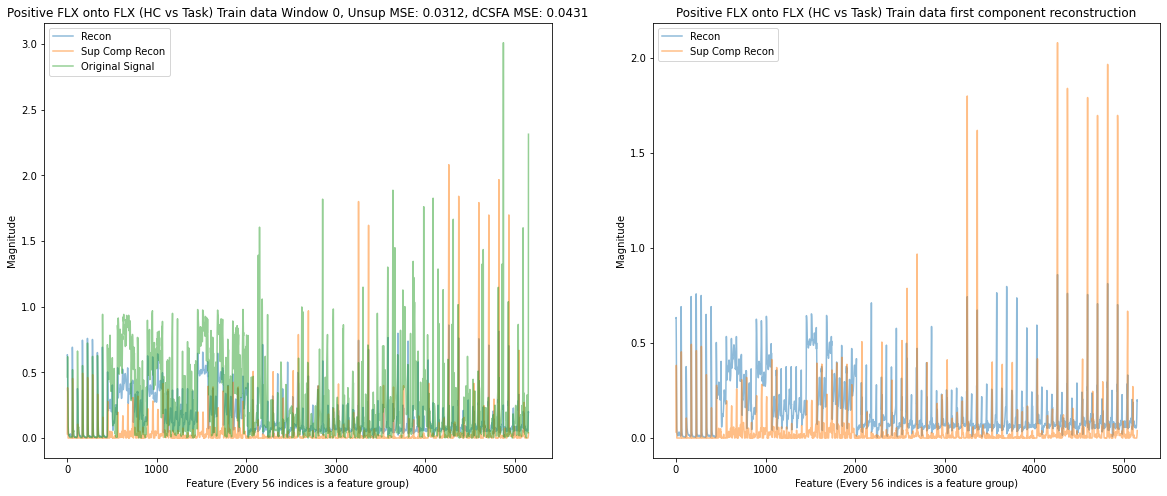

In [5]:
umc_dt.make_recon_plots(model,flx_X_validation,0,task="Positive FLX onto FLX (HC vs Task) Train",saveFile="FLX_Boosted_Power.png")

In [7]:
y_pred, s = model.predict(flx_X_train,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_train,flx_y_mouse_train)
mw_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_train,flx_y_mouse_train,s,True)
print("train roc auc dict: ",roc_auc_dict)
print("train mw auc dict: ",mw_auc_dict)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,flx_y_train,flx_y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

y_pred, s = model.predict(flx_X_validation,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_validation,flx_y_mouse_validation)
mw_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_validation,flx_y_mouse_validation,s,True)
print("validation roc auc dict: ",roc_auc_dict)
print("validation mw auc dict: ",mw_auc_dict)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,flx_y_validation,flx_y_mouse_validation,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

c:\Users\micha\Anaconda3\envs\cpne\lib\site-packages\sklearn\metrics\_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\micha\Anaconda3\envs\cpne\lib\site-packages\sklearn\metrics\_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Mouse  Mouse3202  has only one class - AUC cannot be calculated
n_positive samples  1504
n_negative samples  0
Mouse  Mouse99003  has only one class - AUC cannot be calculated
n_positive samples  1874
n_negative samples  0
train roc auc dict:  {'auc_method': 'sklearn_roc_auc', 'Mouse3191': 0.8731973358282467, 'Mouse3193': 0.8057318415850935, 'Mouse3194': 0.9128882353152072, 'Mouse3202': nan, 'Mouse3203': 0.7563395363527414, 'Mouse99003': nan}
train mw auc dict:  {'auc_method': 'mannWhitneyU', 'Mouse3191': (0.9978500214026351, 0.0), 'Mouse3193': (0.9989134123970939, 0.0), 'Mouse3194': (0.9990768039370578, 0.0), 'Mouse3202': (nan, nan), 'Mouse3203': (0.9983307406759833, 0.0), 'Mouse99003': (nan, nan)}
Mouse  Mouse3202  has only one class - AUC cannot be calculated
n_positive samples  1504
n_negative samples  0
Mouse  Mouse99003  has only one class - AUC cannot be calculated
n_positive samples  1874
n_negative samples  0
train mw auc mean: 1.00 +/- 0.00
validation roc auc dict:  {'auc_met

c:\Users\micha\Desktop\Final_Analyses\.\Universal-Mouse-Code\umc_data_tools.py:274: RuntimeWarning: invalid value encountered in double_scalars
  std = np.std(auc_list) / np.sqrt(len(auc_list)-1)


In [8]:
print(len(np.unique(flx_y_mouse_train)))

6


In [4]:
def getReconContribution(X,n_components,model):
    perc_contribution_list = []
    EPSILON = 1e-6
    X_recon,_,_,s = model.transform(X)
    for component in range(n_components):
        X_recon_comp = model.get_comp_recon(s,component)
        perc_contribution = np.divide(X_recon_comp+EPSILON,X_recon+EPSILON)
        avg_perc_contribution = np.mean(perc_contribution,axis=0)

        perc_contribution_list.append(avg_perc_contribution)
    
    perc_contribution_mat = np.vstack(perc_contribution_list)
    return perc_contribution_mat


perc_contribution_train = getReconContribution(flx_X_train,20,model)
perc_contribution_val = getReconContribution(flx_X_validation,20,model)
positive_mask = flx_y_validation==1
perc_contribution_positive_labels = getReconContribution(flx_X_validation[positive_mask==1],20,model)
perc_contribution_negative_labels = getReconContribution(flx_X_validation[positive_mask==0],20,model)
experiment = "FLX"
#np.savetxt("{}_train_network_perc_contribution.csv".format(experiment),perc_contribution_train)
#np.savetxt("{}_val_network_perc_contribution.csv".format(experiment),perc_contribution_val)
#np.savetxt("{}_val_network_perc_contribution_positive_labels.csv".format(experiment),perc_contribution_positive_labels)
#np.savetxt("{}_val_network_perc_contribution_negative_labels.csv".format(experiment),perc_contribution_negative_labels)

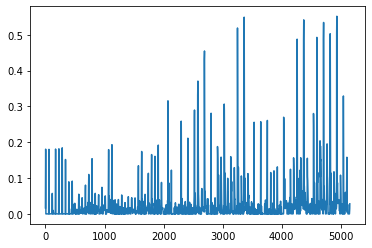

In [9]:
plt.plot(perc_contribution_val[0,:])

### EPM Projections

In [7]:
with open(EPM_TRAIN_FILE,"rb") as f:
    epm_train_dict = pickle.load(f)

with open(EPM_VAL_FILE,"rb") as f:
    epm_validation_dict = pickle.load(f)
#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict["X_power_1_2"],
                    epm_train_dict["X_coh_1_2"],
                    epm_train_dict["X_gc_1_2"]])#*SCALE_VECTOR

y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]

X_val = np.hstack([epm_validation_dict["X_power_1_2"],
                    epm_validation_dict["X_coh_1_2"],
                    epm_validation_dict["X_gc_1_2"]])#*SCALE_VECTOR

y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

epm_X = np.vstack([X_train,X_val])
epm_y_task = np.hstack([y_in_task_mask_train,y_in_task_mask_val])
epm_y_mouse = np.hstack([y_mouse_train,y_mouse_val])
epm_y_time = np.hstack([y_time_train,y_time_val])

y_pred, s = model.predict(epm_X,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,epm_y_task,epm_y_mouse)
mw_auc_dict = umc_dt.lpne_auc(y_pred,epm_y_task,epm_y_mouse,s,True)
print("ROC AUC dict: ",roc_auc_dict)
print("MW auc dict: ",mw_auc_dict)

df = umc_dt.make_projection_csv(EPM_TRAIN_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel','y_locx','y_locy'],
                    save_file = ".\\PosNeg_Results\\{}_FLX_onto_EPM_HC_vs_Task_Train_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict)

df = umc_dt.make_projection_csv(EPM_VAL_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel','y_locx','y_locy'],
                    save_file = ".\\PosNeg_Results\\{}_FLX_onto_EPM_HC_vs_Task_Val_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict)

y_pred, s = model.predict(epm_X,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,epm_y_task,epm_y_mouse)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,epm_y_task,epm_y_mouse,s,True)
print("FLX->EPM roc-auc: {} +/- {}".format(roc_mean,roc_std))
print("FLX->EPM mw-auc: {:0.2f} +/- {:0.2f}".format(mw_mean,mw_std))
#umc_dt.make_recon_plots(model,flx_X,0,task="FLX onto EPM (HC vs Task) Train and Val",saveFile="flx_onto_epm_recon.png")

ROC AUC dict:  {'auc_method': 'sklearn_roc_auc', 'Mouse04193': 0.5214466542113932, 'Mouse04201': 0.5011156031885274, 'Mouse04202': 0.5014925373134329, 'Mouse04205': 0.5, 'Mouse04215': 0.5, 'Mouse0630': 0.4612785130949028, 'Mouse0633': 0.5161001788908766, 'Mouse0634': 0.49912280701754386, 'Mouse0642': 0.5029468523444427, 'Mouse0643': 0.4760355029585799, 'Mouse1551': 0.4958229061616803, 'Mouse39114': 0.494949494949495, 'Mouse39124': 0.5152445614793563, 'Mouse39125': 0.49841685773556066, 'Mouse39133': 0.4844070288056964, 'Mouse6291': 0.48075991208486923, 'Mouse6292': 0.502689172276156, 'Mouse6293': 0.5015477354187032, 'Mouse69064': 0.4931506849315068, 'Mouse69065': 0.5213690872751499, 'Mouse69074': 0.49698795180722893, 'Mouse8580': 0.4782108121112142, 'Mouse8581': 0.469514739229025, 'Mouse8582': 0.5238095238095238, 'Mouse8891': 0.4933227823266278, 'Mouse8894': 0.44197256210604374}
MW auc dict:  {'auc_method': 'mannWhitneyU', 'Mouse04193': (0.47686746188796886, 0.3264773959164843), 'Mouse0

### OFT Projections

In [13]:
with open(OFT_TRAIN_FILE_NAME,'rb') as f:
    train_dict = pickle.load(f)

with open(OFT_VAL_FILE_NAME,'rb') as f:
    val_dict = pickle.load(f)

NUM_FREQS = 56
NUM_FEATURES = np.hstack([train_dict[feature] for feature in FEATURE_VECTOR]).shape[1] // NUM_FREQS

#Train Arrays
oft_X_train = np.hstack([train_dict[feature] for feature in FEATURE_VECTOR])
oft_y_hc_train = train_dict['y_Homecage'].astype(bool)
oft_y_task_train = ~oft_y_hc_train
oft_y_ROI_train = train_dict['y_ROI']
oft_y_vel_train = train_dict['y_vel']
oft_y_mouse_train = train_dict['y_mouse']
oft_y_time_train = train_dict['y_time']

#Validation Arrays
oft_X_val = np.hstack([val_dict[feature] for feature in FEATURE_VECTOR])
oft_y_hc_val = val_dict['y_Homecage'].astype(bool)
oft_y_task_val = ~oft_y_hc_val
oft_y_ROI_val = val_dict['y_ROI']
oft_y_vel_val = val_dict['y_vel']
oft_y_mouse_val = val_dict['y_mouse']
oft_y_time_val = val_dict['y_time']

oft_X = np.vstack([oft_X_train,oft_X_val])
oft_y_task = np.hstack([oft_y_task_train,oft_y_task_val])
oft_y_mouse = np.hstack([oft_y_mouse_train,oft_y_mouse_val])

y_pred, s = model.predict(oft_X,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,oft_y_task,oft_y_mouse)
mw_auc_dict = umc_dt.lpne_auc(y_pred,oft_y_task,oft_y_mouse,s,True)
print("ROC AUC dict: ",roc_auc_dict)
print("MW AUC dict: ",mw_auc_dict)

df = umc_dt.make_projection_csv(OFT_TRAIN_FILE_NAME,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = ".\\PosNeg_Results\\FLX_onto_OFT_HC_vs_Task_Train_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict)

df = umc_dt.make_projection_csv(OFT_VAL_FILE_NAME,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = ".\\PosNeg_Results\\FLX_onto_OFT_HC_vs_Task_Val_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict)

y_pred, s = model.predict(oft_X,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,oft_y_task,oft_y_mouse)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,oft_y_task,oft_y_mouse,s,True)
print("EPM->FLX roc-auc: {} +/- {}".format(roc_mean,roc_std))
print("FLX->OFT mw-auc: {:0.2f} +/- {:0.2f}".format(mw_mean,mw_std))
#umc_dt.make_recon_plots(model,oft_X,0,task="FLX onto OFT (HC vs Task) Train and Val",saveFile="flx_onto_oft_recon.png")

C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  324
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  500
n_negative samples  0
ROC AUC dict:  {'auc_method': 'sklearn_roc_auc', 'Mouse04191': 0.4625889395023153, 'Mouse04193': 0.5240328323978514, 'Mouse04201': 0.5257723759800894, 'Mouse04202': 0.510923464618136, 'Mouse04205': 0.5016784831883124, 'Mouse04215': nan, 'Mouse3191': 0.4538631945386319, 'Mouse3192': nan, 'Mouse3193': 0.4786136872401663, 'Mouse3194': nan, 'Mouse3203': nan, 'Mouse39114': 0.5, 'Mouse39124': 0.5033310749774165, 'Mouse39125': 0.4910498306724722, 'Mouse39133': 0.44440576481236505, 'Mouse69064': 0.5055019830468932, 'Mouse69065': 0.47607798414250024, 'Mouse69072

C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
